In [14]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import warnings

warnings.filterwarnings('ignore')

# --- 0. 环境设置 ---
output_dir = Path('./最终分析结果')
output_dir.mkdir(parents=True, exist_ok=True)
print(f"所有结果将保存在目录: '{output_dir}'")

# --- 1. 数据加载与准备 ---
print("\n--- 步骤一：数据加载与准备 ---")
input_file = Path('../../Data/0/处理后的数据.xlsx')
df_classified = pd.read_excel(input_file, sheet_name='已分类清洗后数据')
df_unclassified = pd.read_excel(input_file, sheet_name='未分类清洗后数据')
print("数据加载成功。")

non_chemical_cols = ['文物编号', '文物采样点', '类型', '颜色', '纹饰', '表面风化', '成分总和']
chemical_columns = [col for col in df_classified.columns if col not in non_chemical_cols]

combined_weathering = pd.concat([df_classified[['表面风化']], df_unclassified[['表面风化']]], axis=0)
weathering_one_hot = pd.get_dummies(combined_weathering['表面风化'], prefix='表面风化')
df_classified_weathering = weathering_one_hot.iloc[:len(df_classified)]
df_unclassified_weathering = weathering_one_hot.iloc[len(df_classified):]
df_classified_weathering.index = df_classified.index
df_unclassified_weathering.index = df_unclassified.index
le = LabelEncoder()
y_full = le.fit_transform(df_classified['类型'])

X_full_chem = df_classified[chemical_columns]
X_full = pd.concat([X_full_chem, df_classified_weathering], axis=1)

scaler = StandardScaler()
X_full[chemical_columns] = scaler.fit_transform(X_full[chemical_columns])
print("数据准备完成。")

# --- 2. 初步模型对比 (探索性) ---
print("\n--- 步骤二：初步模型对比 ---")
models_initial = {
    '决策树': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'KNN': KNeighborsClassifier()
}
cv_splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring_metrics = ['accuracy', 'f1_macro']

results_initial = {}
for name, model in models_initial.items():
    cv_results = cross_validate(model, X_full, y_full, cv=cv_splitter, scoring=scoring_metrics)
    results_initial[name] = {
        '准确率': f"{np.mean(cv_results['test_accuracy']):.4f}",
        'F1分数': f"{np.mean(cv_results['test_f1_macro']):.4f}"
    }

results_df_initial = pd.DataFrame(results_initial).T
results_df_initial.index.name = '模型'
print("\n--- 初步模型性能对比表 (含PbO) ---")
print(results_df_initial.to_markdown())
results_df_initial.to_csv(output_dir / '初步模型性能对比表.csv', encoding='utf-8-sig')

所有结果将保存在目录: '最终分析结果'

--- 步骤一：数据加载与准备 ---
数据加载成功。
数据准备完成。

--- 步骤二：初步模型对比 ---

--- 初步模型性能对比表 (含PbO) ---
| 模型   |   准确率 |   F1分数 |
|:-------|---------:|---------:|
| 决策树 |   1      |   1      |
| SVM    |   0.9714 |   0.9576 |
| KNN    |   0.9857 |   0.9788 |



--- 步骤三：深入探究决策树 ---

决策树模型给出的特征重要性：
氧化铅(PbO)    1.0
dtype: float64

[分析结论]: 特征重要性显示，决策树模型几乎100%依赖于'氧化铅(PbO)'进行分类。

[可视化证据]: 初步决策树的可视化图已保存至 '最终分析结果\初步决策树可视化图.png'。


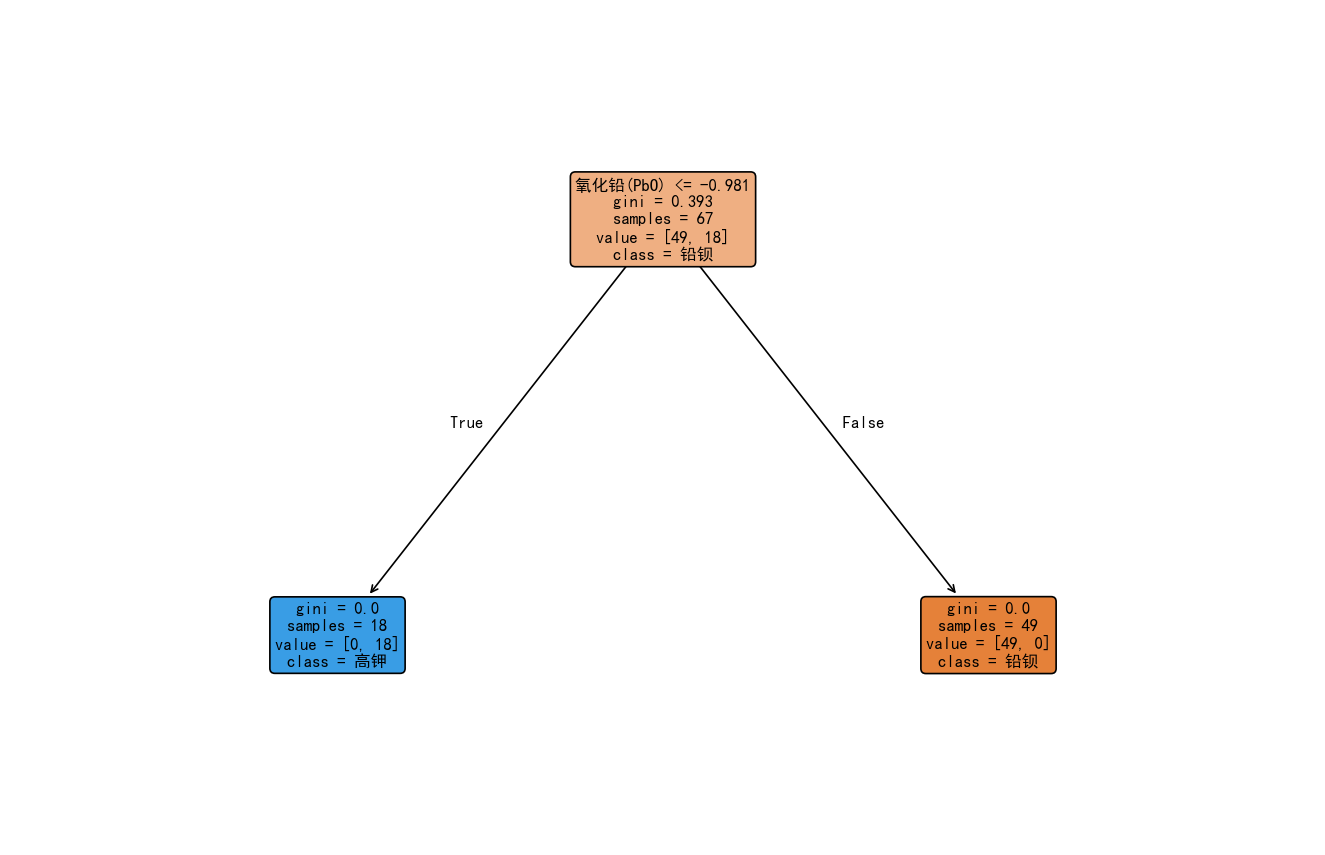

In [15]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# 假设上一个代码块已成功运行，X_full, y_full等变量已存在
print("\n--- 步骤三：深入探究决策树 ---")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 120

# (3.1) 特征重要性分析
dt_explorer = DecisionTreeClassifier(random_state=42)
dt_explorer.fit(X_full, y_full)
importances = pd.Series(dt_explorer.feature_importances_, index=X_full.columns).sort_values(ascending=False)
print("\n决策树模型给出的特征重要性：")
print(importances[importances > 0])
print("\n[分析结论]: 特征重要性显示，决策树模型几乎100%依赖于'氧化铅(PbO)'进行分类。")

# (3.2) 决策树可视化
plt.figure(figsize=(14, 9))
plot_tree(
    dt_explorer,
    filled=True,
    feature_names=X_full.columns.tolist(),
    class_names=le.classes_.tolist(),
    rounded=True,
    fontsize=10,
    max_depth=2
)
tree_fig_path = output_dir / '初步决策树可视化图.png'
plt.savefig(tree_fig_path, bbox_inches='tight')
print(f"\n[可视化证据]: 初步决策树的可视化图已保存至 '{tree_fig_path}'。")

In [16]:
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Categorical, Integer

# 假设之前的代码块已成功运行
print("\n--- 步骤四：采用IGA-SVM进行最终建模 ---")
print("\n[决策]: 拒绝过于简单的决策树，采用IGA-SVM构建更稳健的模型。")

# (4.1) IGA-SVM 参数寻优
estimator_svm = SVC(probability=True, random_state=42)

# 【核心修正】使用库自带的类来定义参数空间
param_grid_svm = {
    'C': Continuous(0.1, 100, distribution='log-uniform'),
    'gamma': Continuous(0.001, 1, distribution='log-uniform'),
    'kernel': Categorical(['rbf', 'linear'])
}

gscv = GASearchCV(
    estimator=estimator_svm,
    param_grid=param_grid_svm,
    cv=cv_splitter,
    scoring='f1_macro',
    population_size=15,
    generations=30,
    verbose=True,
    n_jobs=-1
)
print("\n开始运行IGA-SVM进行超参数寻优 (可能需要几分钟)...")
gscv.fit(X_full, y_full)

print("\n--- IGA-SVM 寻优结果 ---")
print(f"找到的最优参数: {gscv.best_params_}")
print(f"达到的最佳F1分数 (10折交叉验证): {gscv.best_score_:.4f}")

# 将最终训练好的模型保存到变量中，以供下一步使用
final_model = gscv.best_estimator_
print("\nIGA-SVM最优模型已确定并训练完成！")


--- 步骤四：采用IGA-SVM进行最终建模 ---

[决策]: 拒绝过于简单的决策树，采用IGA-SVM构建更稳健的模型。

开始运行IGA-SVM进行超参数寻优 (可能需要几分钟)...
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	15    	0.885838	0.153173   	1          	0.422576   
1  	30    	0.968687	0.043783   	1          	0.806061   
2  	30    	0.985859	0.00999949 	1          	0.978788   
3  	30    	0.987273	0.0103918  	1          	0.978788   
4  	30    	0.998586	0.00529123 	1          	0.978788   
5  	30    	0.998586	0.00529123 	1          	0.978788   
6  	30    	0.998586	0.00529123 	1          	0.978788   
7  	30    	1       	0          	1          	1          
8  	30    	1       	0          	1          	1          
9  	30    	1       	0          	1          	1          
10 	30    	1       	0          	1          	1          
11 	30    	1       	0          	1          	1          
12 	30    	1       	0          	1          	1          
13 	30    	1       	0          	1          	1          
14 	30    	1       	0          	1          	1          
15 	3

--- 正在解析IGA-SVM训练日志数据 ---
--- 正在绘制最终版3D瀑布式收敛过程图 ---
最终版3D瀑布图已成功保存至: '最终分析结果\IGA-SVM寻优过程3D瀑布图_最终版.png'


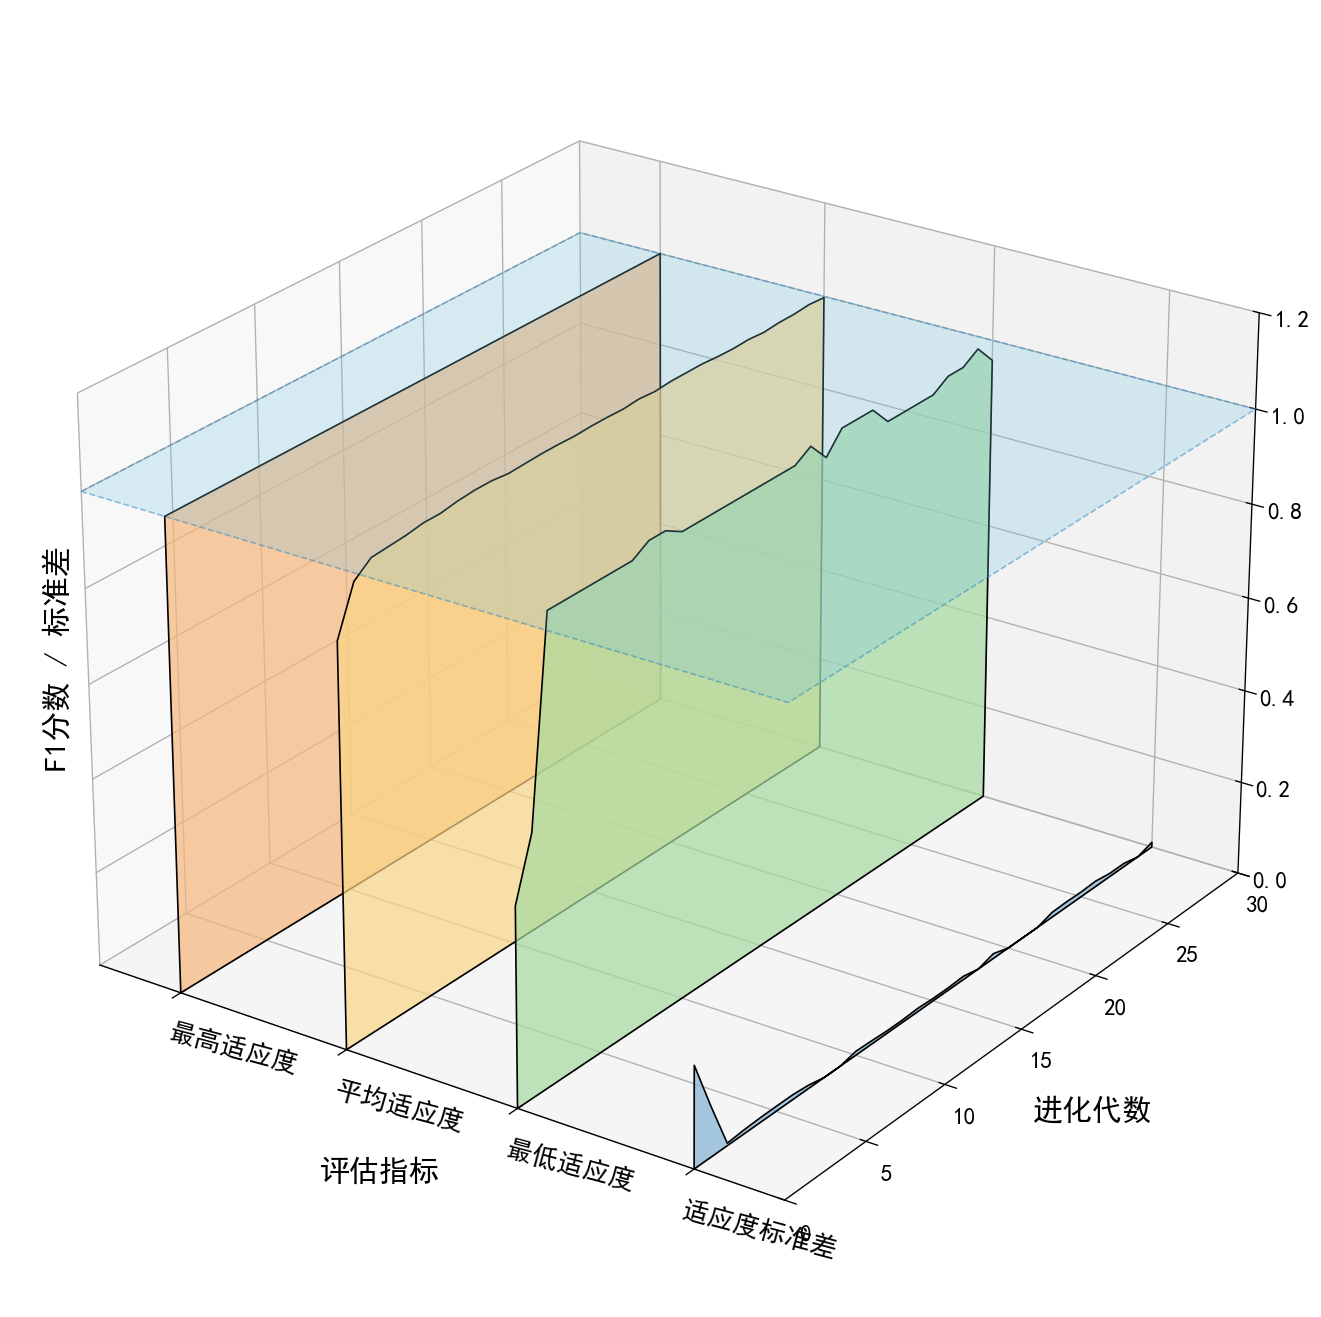

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from pathlib import Path
import io

# ==============================================================================
# 1. 准备数据
# ==============================================================================
print("--- 正在解析IGA-SVM训练日志数据 ---")
log_data_string = """
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	15    	0.851424	0.215463   	1          	0.422576
1  	30    	0.951707	0.107126   	1          	0.551364
2  	30    	0.980202	0.00529123 	1          	0.978788
3  	30    	0.98303 	0.00848485 	1          	0.978788
4  	30    	0.985859	0.00999949 	1          	0.978788
5  	30    	0.991515	0.0103918  	1          	0.978788
6  	30    	0.991515	0.0103918  	1          	0.978788
7  	30    	0.997172	0.00721073 	1          	0.978788
8  	30    	1       	0          	1          	1
9  	30    	1       	0          	1          	1
10 	30    	0.995758	0.008485 	1          	0.978788
11 	30    	0.997172	0.00721073 	1          	0.978788
12 	30    	0.998586	0.00529123 	1          	0.978788
13 	30    	0.998586	0.00529123 	1          	0.978788
14 	30    	0.997172	0.00721073 	1          	0.978788
15 	30    	0.998586	0.00529123 	1          	0.978788
16 	30    	0.998586	0.00529123 	1          	0.978788
17 	30    	0.997172	0.00721073 	1          	0.978788
18 	30    	1       	0          	1          	1
19 	30    	0.997172	0.0105825  	1          	0.957576
20 	30    	1       	0          	1          	1
21 	30    	1       	0          	1          	1
22 	30    	1       	0          	1          	1
23 	30    	0.997172	0.0105825  	1          	0.957576
24 	30    	0.995758	0.0114885  	1          	0.957576
25 	30    	0.997172	0.0105825  	1          	0.957576
26 	30    	0.994343	0.0121649  	1          	0.957576
27 	30    	0.997172	0.00721073 	1          	0.978788
28 	30    	0.997172	0.00721073 	1          	0.978788
29 	30    	1       	0          	1          	1
30 	30    	0.997172	0.0105825  	1          	0.957576
"""
log_df = pd.read_csv(io.StringIO(log_data_string), sep='\s+')

# ==============================================================================
# 2. 绘制最终版3D瀑布图
# ==============================================================================
print("--- 正在绘制最终版3D瀑布式收敛过程图 ---")
# 遵照您的要求进行绘图设置
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelpad'] = 20

fig = plt.figure(figsize=(20, 14))
ax = fig.add_subplot(111, projection='3d')

# --- (2.1) 定义类别和颜色 ---
colors = ['#F7B67B', '#FAD586', '#a6dba0', '#80b1d3']
metrics = ['fitness_max', 'fitness', 'fitness_min', 'fitness_std']
metric_labels = ['最高适应度', '平均适应度', '最低适应度', '适应度标准差']
metric_positions = np.arange(len(metrics))

# --- (2.2) 绘制瀑布面积图 ---
all_verts = []
for metric in metrics:
    y_values = log_df['gen'].values
    z_values = log_df[metric].values
    verts = [(y_values.min(), 0)] + list(zip(y_values, z_values)) + [(y_values.max(), 0)]
    all_verts.append(verts)

poly = PolyCollection(all_verts, facecolors=[c + 'B3' for c in colors],
                      edgecolors='black', linewidths=1.0)
ax.add_collection3d(poly, zs=metric_positions, zdir='x')

# --- (2.3) 绘制浅蓝色收敛平面 ---
convergence_value = 1.0
y_corners = [log_df['gen'].min(), log_df['gen'].max(), log_df['gen'].max(), log_df['gen'].min()]
x_corners = [metric_positions.min() - 0.5, metric_positions.min() - 0.5, metric_positions.max() + 0.5, metric_positions.max() + 0.5]
verts_plane_2d = [list(zip(x_corners, y_corners))]
poly_plane = PolyCollection(verts_plane_2d, facecolors=['#74C4E340'], edgecolors='#2E86C180', linestyle='--')
ax.add_collection3d(poly_plane, zs=[convergence_value], zdir='z')

# --- (2.4) 美化与标签 ---
ax.set_xlabel('评估指标', fontsize=18)
ax.set_ylabel('进化代数', fontsize=18)

# 【最终修正】使用 text2D 将Z轴标签放置在相对于整个图表的位置，确保可见
ax.set_zlabel('') # 清空默认标签
ax.text2D(0.035, 0.5, 'F1分数 / 标准差',
          transform=ax.transAxes, # 使用相对于坐标轴的坐标系
          rotation=90, # 旋转90度
          va='center', # 垂直居中
          ha='center', # 水平居中
          fontsize=18)

ax.set_xlim(-0.5, len(metrics) - 0.5)
ax.set_ylim(log_df['gen'].min(), log_df['gen'].max())
ax.set_zlim(0, 1.2)

ax.set_xticks(metric_positions)
ax.set_xticklabels(metric_labels, fontsize=16, rotation=-15, ha='left')

ax.view_init(elev=25, azim=-55)
ax.grid(True, linestyle=':', alpha=0.5)

# ==============================================================================
# 3. 保存图片
# ==============================================================================
output_dir = Path('./最终分析结果')
output_dir.mkdir(parents=True, exist_ok=True)
figure_path = output_dir / 'IGA-SVM寻优过程3D瀑布图_最终版.png'
# 使用 fig.tight_layout() 可以在保存前尝试自动调整布局
fig.tight_layout(pad=1.5)
plt.savefig(figure_path, dpi=300)

print(f"最终版3D瀑布图已成功保存至: '{figure_path}'")
# plt.show()

所有结果将保存在目录: '最终分析结果'

--- 步骤一：数据加载与准备 ---
数据加载失败，请确保 '处理后的数据.xlsx' 文件在同一目录下。错误: [Errno 2] No such file or directory: '处理后的数据.xlsx'
数据准备完成。

--- 步骤二：初步模型对比 ---

--- 初步模型性能对比表 (含PbO) ---
| 模型   |   准确率 |   F1分数 |
|:-------|---------:|---------:|
| 决策树 |   1      |   1      |
| SVM    |   0.9714 |   0.9576 |
| KNN    |   0.9857 |   0.9788 |

--- 步骤三：深入探究决策树 ---

决策树模型给出的特征重要性：
氧化铅(PbO)    1.0
dtype: float64

[分析结论]: 特征重要性显示，决策树模型高度依赖于'氧化铅(PbO)'进行分类。

[可视化证据]: 初步决策树的可视化图已保存至 '最终分析结果\初步决策树可视化图.png'。

--- 步骤四：采用IGA-SVM进行最终建模与分析 ---

[决策]: 尽管决策树准确率高，但模型过于简单，泛化能力存疑。为构建更稳健的模型，我们采用IGA-SVM。

开始运行IGA-SVM进行超参数寻优 (可能需要几分钟)...
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	15    	0.914424	0.139127   	1          	0.422576   
1  	30    	0.984444	0.00938035 	1          	0.978788   
2  	30    	0.992929	0.00999949 	1          	0.978788   
3  	30    	0.988687	0.0131142  	1          	0.957576   
4  	30    	0.994343	0.0121649  	1          	0.957576   
5  	30    	0.997172	0.00721073 	1          	

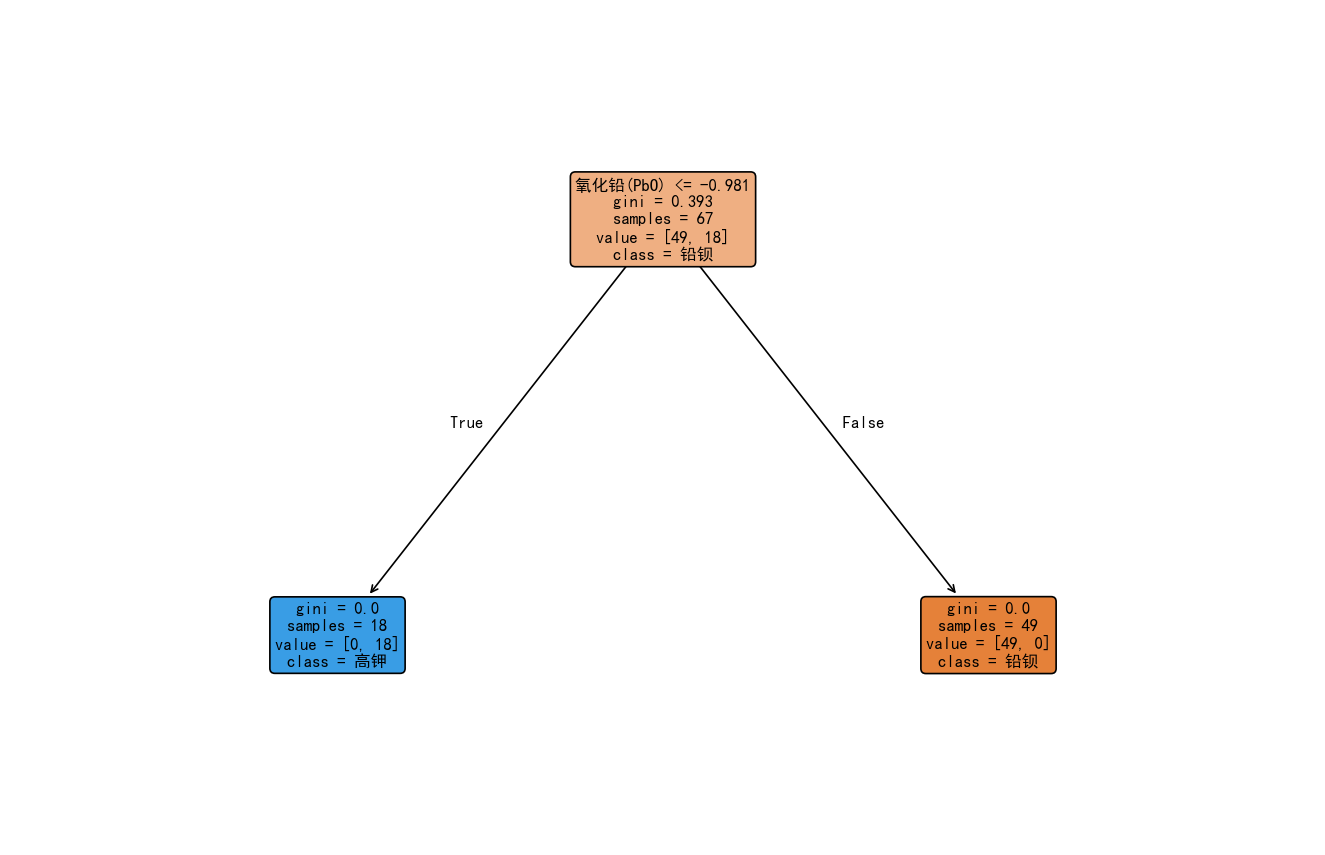

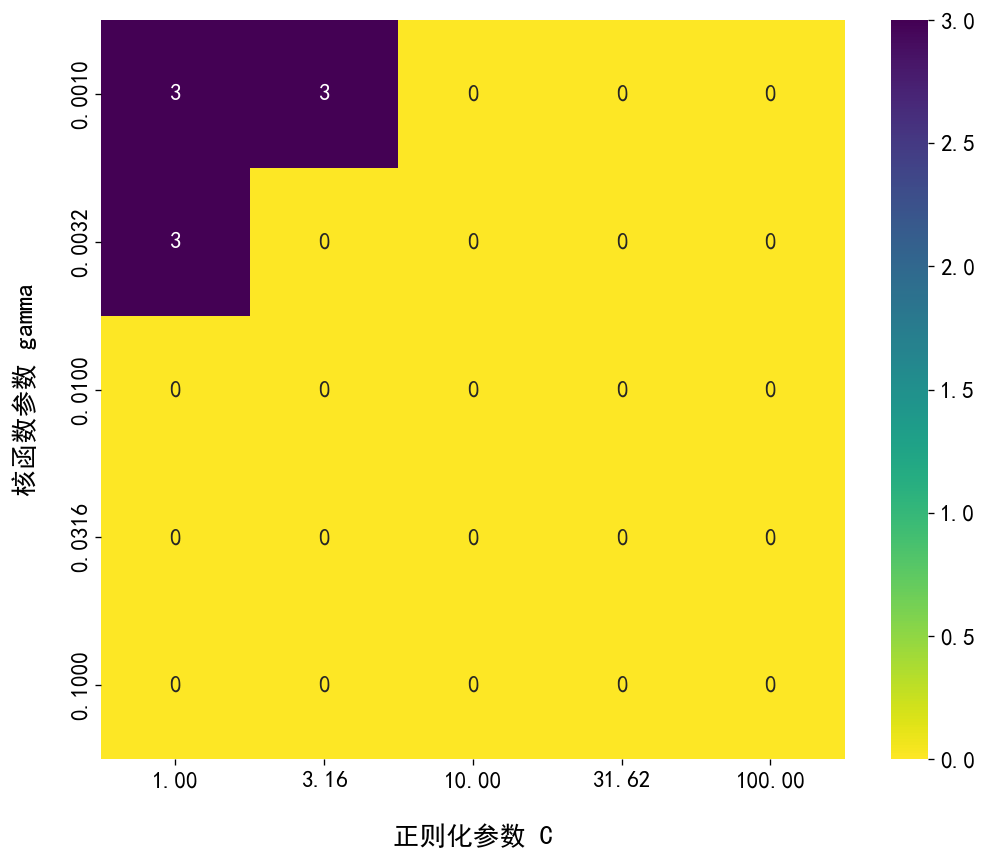

: 

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Categorical
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings

# ==============================================================================
# 0. 环境设置
# ==============================================================================
# 忽略警告
warnings.filterwarnings('ignore')
# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 120

# 输出目录
output_dir = Path('./最终分析结果')
output_dir.mkdir(parents=True, exist_ok=True)
print(f"所有结果将保存在目录: '{output_dir}'")

# ==============================================================================
# 步骤一：数据加载与准备
# ==============================================================================
print("\n--- 步骤一：数据加载与准备 ---")
try:
    input_file = Path('./处理后的数据.xlsx')
    df_classified = pd.read_excel(input_file, sheet_name='已分类清洗后数据')
    df_unclassified = pd.read_excel(input_file, sheet_name='未分类清洗后数据')
    print("数据加载成功。")
except Exception as e:
    print(f"数据加载失败，请确保 '处理后的数据.xlsx' 文件在同一目录下。错误: {e}")
    exit()

# 定义特征集 (本次分析包含所有化学成分)
non_chemical_cols = ['文物编号', '文物采样点', '类型', '颜色', '纹饰', '表面风化', '成分总和']
chemical_columns = [col for col in df_classified.columns if col not in non_chemical_cols]

# 数据量化
combined_weathering = pd.concat([df_classified[['表面风化']], df_unclassified[['表面风化']]], axis=0)
weathering_one_hot = pd.get_dummies(combined_weathering['表面风化'], prefix='表面风化')
df_classified_weathering = weathering_one_hot.iloc[:len(df_classified)]
df_unclassified_weathering = weathering_one_hot.iloc[len(df_classified):]
df_classified_weathering.index = df_classified.index
df_unclassified_weathering.index = df_unclassified.index
le = LabelEncoder()
y_full = le.fit_transform(df_classified['类型'])

# 构建数据集
X_full_chem = df_classified[chemical_columns]
X_full = pd.concat([X_full_chem, df_classified_weathering], axis=1)
X_predict_chem = df_unclassified[chemical_columns]
X_predict = pd.concat([X_predict_chem, df_unclassified_weathering], axis=1)

if '文物采样点' in df_unclassified.columns:
    predict_identifiers = df_unclassified['文物采样点']
else:
    predict_identifiers = pd.Series(range(len(df_unclassified)), name="样本序号")

# 数据标准化
scaler = StandardScaler()
X_full[chemical_columns] = scaler.fit_transform(X_full[chemical_columns])
X_predict[chemical_columns] = scaler.transform(X_predict[chemical_columns])
print("数据准备完成。")


# ==============================================================================
# 步骤二：初步模型对比 (探索性)
# ==============================================================================
print("\n--- 步骤二：初步模型对比 ---")
models_initial = {
    '决策树': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'KNN': KNeighborsClassifier()
}
cv_splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring_metrics = ['accuracy', 'f1_macro']

results_initial = {}
for name, model in models_initial.items():
    cv_results = cross_validate(model, X_full, y_full, cv=cv_splitter, scoring=scoring_metrics)
    results_initial[name] = {
        '准确率': f"{np.mean(cv_results['test_accuracy']):.4f}",
        'F1分数': f"{np.mean(cv_results['test_f1_macro']):.4f}"
    }

results_df_initial = pd.DataFrame(results_initial).T
results_df_initial.index.name = '模型'
print("\n--- 初步模型性能对比表 (含PbO) ---")
print(results_df_initial.to_markdown())
results_df_initial.to_csv(output_dir / '初步模型性能对比表.csv', encoding='utf-8-sig')


# ==============================================================================
# 步骤三：深入探究决策树为何是1.0
# ==============================================================================
print("\n--- 步骤三：深入探究决策树 ---")
dt_explorer = DecisionTreeClassifier(random_state=42)
dt_explorer.fit(X_full, y_full)
importances = pd.Series(dt_explorer.feature_importances_, index=X_full.columns).sort_values(ascending=False)
print("\n决策树模型给出的特征重要性：")
print(importances[importances > 0])
print("\n[分析结论]: 特征重要性显示，决策树模型高度依赖于'氧化铅(PbO)'进行分类。")

plt.figure(figsize=(14, 9))
plot_tree(
    dt_explorer, filled=True, feature_names=X_full.columns.tolist(),
    class_names=le.classes_.tolist(), rounded=True, fontsize=10, max_depth=2
)
tree_fig_path = output_dir / '初步决策树可视化图.png'
plt.savefig(tree_fig_path, bbox_inches='tight')
print(f"\n[可视化证据]: 初步决策树的可视化图已保存至 '{tree_fig_path}'。")


# ==============================================================================
# 步骤四：拒绝简单模型，采用IGA-SVM进行最终建模与分析
# ==============================================================================
print("\n--- 步骤四：采用IGA-SVM进行最终建模与分析 ---")
print("\n[决策]: 尽管决策树准确率高，但模型过于简单，泛化能力存疑。为构建更稳健的模型，我们采用IGA-SVM。")
# (4.1) IGA-SVM 参数寻优
estimator_svm = SVC(probability=True, random_state=42)
param_grid_svm = {
    'C': Continuous(0.1, 100, distribution='log-uniform'),
    'gamma': Continuous(0.001, 1, distribution='log-uniform'),
    'kernel': Categorical(['rbf', 'linear'])
}
gscv = GASearchCV(
    estimator=estimator_svm, param_grid=param_grid_svm, cv=cv_splitter, scoring='f1_macro',
    population_size=15, generations=30, verbose=True, n_jobs=-1
)
print("\n开始运行IGA-SVM进行超参数寻优 (可能需要几分钟)...")
gscv.fit(X_full, y_full)
print("\n--- IGA-SVM 寻优结果 ---")
print(f"找到的最优参数: {gscv.best_params_}")
print(f"达到的最佳F1分数 (10折交叉验证): {gscv.best_score_:.4f}")

# (4.2) 使用最优模型进行最终预测
final_model = gscv.best_estimator_
print("\nIGA-SVM最优模型已确定并训练完成。")
predictions_encoded = final_model.predict(X_predict)
predictions_decoded = le.inverse_transform(predictions_encoded)
prediction_results_df = pd.DataFrame({'样本标识': predict_identifiers, '预测类别': predictions_decoded})
print("\n--- 对未知样本的最终预测结果 ---")
print(prediction_results_df.to_markdown(index=False))
prediction_results_df.to_csv(output_dir / '最终预测结果.csv', index=False, encoding='utf-8-sig')

# (4.3) 最终灵敏度分析
print("\n--- 开始进行最终灵敏度分析 ---")
# 蒙特卡洛分析
j_simulations = 1000
flip_counts = np.zeros(len(X_predict))
for _ in range(j_simulations):
    X_predict_perturbed = X_predict.copy()
    sample_indices = random.sample(range(len(X_predict)), 4)
    for sample_idx in sample_indices:
        feature_names = random.sample(chemical_columns, 5)
        for feature_name in feature_names:
            original_value = X_predict_perturbed.iloc[sample_idx][feature_name]
            noise = original_value * random.uniform(0, 0.05)
            X_predict_perturbed.loc[X_predict_perturbed.index[sample_idx], feature_name] += noise
    perturbed_preds = final_model.predict(X_predict_perturbed)
    flip_counts += (perturbed_preds != predictions_encoded)
instability_scores = flip_counts / j_simulations
sensitivity_df = pd.DataFrame({
    '样本标识': predict_identifiers, '初始预测类别': predictions_decoded,
    '预测不稳定性得分': instability_scores
})
print("\n--- 蒙特卡洛分析结果：预测不稳定性得分 ---")
print(sensitivity_df.to_markdown(index=False))
sensitivity_df.to_csv(output_dir / '蒙特卡洛灵敏度分析结果.csv', index=False, encoding='utf-8-sig')

# SVM超参数敏感性分析
print("\n--- 开始进行SVM超参数敏感性分析 ---")
C_range = np.logspace(0, 2, 5)
gamma_range = np.logspace(-3, -1, 5)
heatmap_data = np.zeros((len(gamma_range), len(C_range)))
for i, gamma in enumerate(gamma_range):
    for j, C in enumerate(C_range):
        temp_model = SVC(C=C, gamma=gamma, random_state=42).fit(X_full, y_full)
        temp_preds = temp_model.predict(X_predict)
        heatmap_data[i, j] = np.sum(temp_preds != predictions_encoded)

plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data, annot=True, fmt=".0f", cmap='viridis_r',
    xticklabels=[f"{c:.2f}" for c in C_range],
    yticklabels=[f"{g:.4f}" for g in gamma_range]
)
plt.xlabel("正则化参数 C")
plt.ylabel("核函数参数 gamma")
heatmap_fig_path = output_dir / 'SVM超参数敏感性分析热图.png'
plt.savefig(heatmap_fig_path, bbox_inches='tight')
print(f"\nSVM超参数敏感性分析热图已保存至: '{heatmap_fig_path}'")
print("\n--- 全部流程执行完毕 ---")

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import warnings

# 忽略一些版本更新可能产生的警告
warnings.filterwarnings('ignore')

# ==============================================================================
# 1. 环境与数据准备
# ==============================================================================
print("--- 补充实验：移除PbO后的模型对比分析 ---")
# 假设之前的代码块已运行，或重新加载数据
try:
    input_file = Path('../../Data/0/处理后的数据.xlsx')
    output_dir = Path('./最终分析结果') # 确保输出到同一目录
    df_classified = pd.read_excel(input_file, sheet_name='已分类清洗后数据')
    print("\n数据加载成功。")
except Exception as e:
    print(f"数据加载失败: {e}")
    exit()

# --- (1.1) 【核心修改】应用新的特征筛选决策 ---
# 在原有的基础上，额外剔除 氧化铅(PbO)
features_to_remove_base = ['氧化铝(Al2O3)', '氧化镁(MgO)', '氧化铁(Fe2O3)']
features_to_remove_new = features_to_remove_base + ['氧化铅(PbO)']

# 确定化学成分列
non_chemical_cols = ['文物编号', '文物采样点', '类型', '颜色', '纹饰', '表面风化', '成分总和']
chemical_columns = [col for col in df_classified.columns if col not in non_chemical_cols]

# 生成最终的化学特征白名单 (现在应该只剩10个)
selected_chemical_features = [col for col in chemical_columns if col not in features_to_remove_new]
print(f"已根据新决策，筛选出 {len(selected_chemical_features)} 个化学特征。")
print("本次实验剔除的特征:", features_to_remove_new)

# --- (1.2) 数据量化与构建 (流程不变) ---
weathering_one_hot = pd.get_dummies(df_classified['表面风化'], prefix='表面风化')
le = LabelEncoder()
y_full = le.fit_transform(df_classified['类型'])

X_full_chem = df_classified[selected_chemical_features]
X_full_no_pbo = pd.concat([X_full_chem, weathering_one_hot], axis=1)

# --- (1.3) 数据标准化 (流程不变) ---
scaler = StandardScaler()
X_full_no_pbo[selected_chemical_features] = scaler.fit_transform(X_full_no_pbo[selected_chemical_features])
print("不含PbO的数据准备完成。")


# ==============================================================================
# 2. 在新数据集上重新进行模型对比评估
# ==============================================================================
print("\n在不含PbO的数据集上，重新进行10折交叉验证...")
# 定义模型
models = {
    'SVM': SVC(probability=True, random_state=42),
    '决策树': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier()
}

# 设置交叉验证
cv_splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring_metrics = ['accuracy', 'f1_macro']

# 执行评估
results = {}
for model_name, model in models.items():
    print(f"正在评估模型: {model_name}...")
    # 注意：这里使用不含PbO的数据 X_full_no_pbo
    cv_results = cross_validate(model, X_full_no_pbo, y_full, cv=cv_splitter, scoring=scoring_metrics)
    results[model_name] = {
        '准确率': f"{np.mean(cv_results['test_accuracy']):.4f}",
        'F1分数 (宏平均)': f"{np.mean(cv_results['test_f1_macro']):.4f}"
    }

# ==============================================================================
# 3. 输出新的对比表格
# ==============================================================================
results_df = pd.DataFrame(results).T
results_df.index.name = '模型'
markdown_table = results_df.to_markdown()

print("\n--- [补充实验]模型性能对比表 (不含PbO特征) ---")
print(markdown_table)

# 保存新的表格到文件
table_csv_file = output_dir / '模型性能对比表(无PbO).csv'
table_md_file = output_dir / '模型性能对比表(无PbO).md'
results_df.to_csv(table_csv_file, encoding='utf-8-sig')
with open(table_md_file, 'w', encoding='utf-8') as f:
    f.write("# [补充实验]模型性能对比表 (不含PbO特征)\n\n")
    f.write(markdown_table)
    
print(f"\n补充实验的对比表格已保存至: '{table_csv_file}' 和 '{table_md_file}'")
print("--------------------------------------------------")

--- 补充实验：移除PbO后的模型对比分析 ---

数据加载成功。
已根据新决策，筛选出 10 个化学特征。
本次实验剔除的特征: ['氧化铝(Al2O3)', '氧化镁(MgO)', '氧化铁(Fe2O3)', '氧化铅(PbO)']
不含PbO的数据准备完成。

在不含PbO的数据集上，重新进行10折交叉验证...
正在评估模型: SVM...
正在评估模型: 决策树...
正在评估模型: KNN...

--- [补充实验]模型性能对比表 (不含PbO特征) ---
| 模型   |   准确率 |   F1分数 (宏平均) |
|:-------|---------:|------------------:|
| SVM    |   0.9857 |            0.9788 |
| 决策树 |   0.9429 |            0.9265 |
| KNN    |   0.9262 |            0.898  |

补充实验的对比表格已保存至: '最终分析结果\模型性能对比表(无PbO).csv' 和 '最终分析结果\模型性能对比表(无PbO).md'
--------------------------------------------------
